### Imports and database initialization

In [2]:
from sqlalchemy import select, func
from gorillatracker.ssl_pipeline.models import Tracking, Video, Camera
from sqlalchemy.orm import sessionmaker
from gorillatracker.ssl_pipeline.dataset import GorillaDatasetKISZ

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import numpy as np

engine = GorillaDatasetKISZ().engine
session_cls = sessionmaker(bind=engine)

### Number of Videos with x tracklets

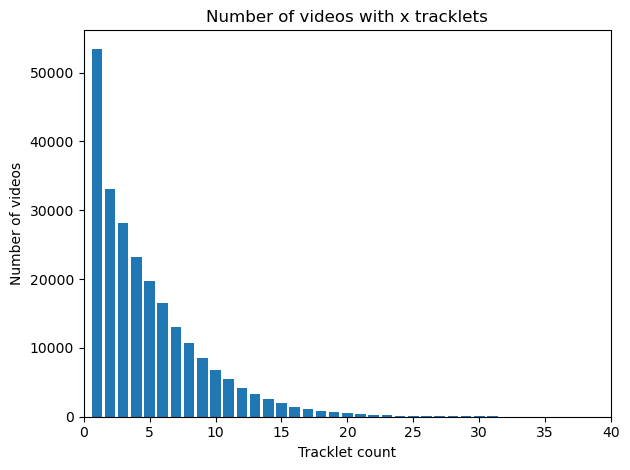

In [8]:
stmt = (
    select(Tracking.video_id, func.count(Tracking.tracking_id).label("count"))
    .group_by(Tracking.video_id)
    )

with session_cls() as session:
    result = session.execute(stmt)
    sorted_all = sorted(result.fetchall(), key=lambda x: x[1], reverse=True)

res = {}

for video_id, count in sorted_all:
    if count not in res:
        res[count] = 1
    res[count] += 1

res = res.items()

list1, list2 = zip(*res)
plt.bar(list1, list2)
plt.xlabel("Tracklet count")
plt.ylabel("Number of videos")
plt.xlim(0,40)
plt.title("Number of videos with x tracklets")
plt.tight_layout()
plt.show()

### Tracklet distribution heatmap over camera positions

IntProgress(value=0, max=91)

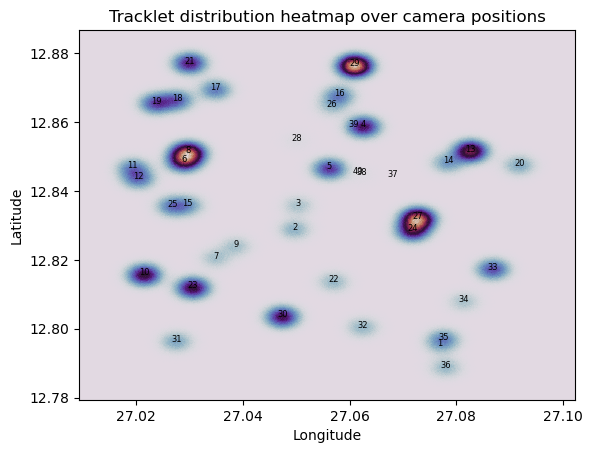

In [27]:
from ipywidgets import IntProgress

stmt = (
    select(Video.camera_id, func.sum(Tracking.tracking_id).label("count"))
    .join(Tracking, Video.video_id == Tracking.video_id)
    .group_by(Video.camera_id)
    )

with session_cls() as session:
    result = session.execute(stmt)
    all = sorted(result.fetchall(), key=lambda x: x[0])

stmt = (
    select(Camera.camera_id, Camera.longitude, Camera.latitude)
    )

with session_cls() as session:
    result = session.execute(stmt)
    all2 = sorted(result.fetchall(), key=lambda x: x[0])

mapping = {x : (y,z) for x, y, z in all2}

f = IntProgress(min=0, max=len(all)) # instantiate the bar
display(f)

points = []
for (camera_id, count) in all:
    f.value += 1
    (long, lat) = mapping[camera_id]
    if long is None or lat is None:
        continue
    for i in range(count//10000):
        points.append((long + np.random.normal(0, 0.002), lat + np.random.normal(0, 0.002)))

x, y = zip(*points)

plt.hist2d(x,y, bins=1000, cmap="twilight")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Tracklet distribution heatmap over camera positions")
for i, (x, y) in mapping.items():
    if x is None or y is None:
        continue
    plt.text(x, y, f"{i}", ha="center", fontsize=6)

plt.show()

### Number of Videos per Date

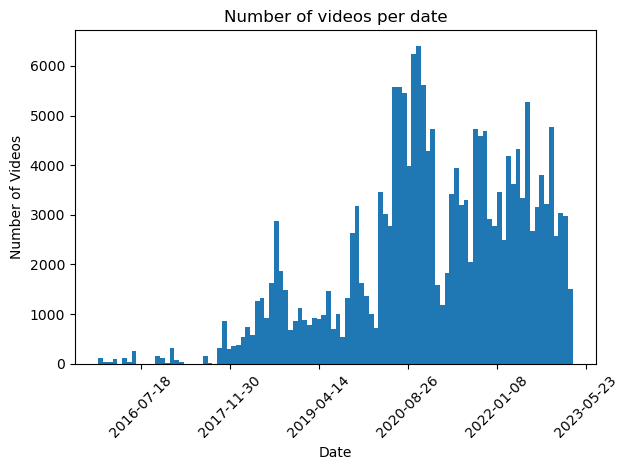

In [24]:
with session_cls() as session:
    result = session.execute(select(Video.start_time))
    all = result.fetchall()
    
all_dates = [mdates.date2num(date[0].date()) for date in all if date[0] is not None and date[0].date().year > 2000]

fig, ax = plt.subplots()
ax.hist(all_dates, bins=100)
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.xlabel("Date")
plt.ylabel("Number of Videos")
plt.xticks(rotation=45)
plt.title("Number of videos per date")
plt.tight_layout()
plt.show()


### Length of Videos

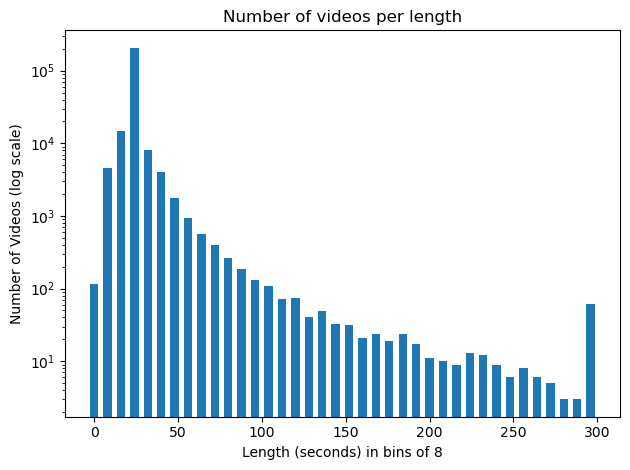

In [3]:
stmt = (
    select((Video.frames / Video.fps).label("duration"), func.count(Video.video_id).label("count"))
    .group_by("duration")
    )

with session_cls() as session:
    result = session.execute(stmt)
    all = result.fetchall()

res = {}

bins = 8
for length, count in all:
    if length // bins * bins not in res:
        res[length // bins * bins] = 0
    res[length // bins * bins] += count

list1, list2 = zip(*res.items())
plt.bar(list1, list2, width=5)
plt.xlabel(f"Length (seconds) in bins of {bins}")
plt.ylabel("Number of Videos (log scale)")
plt.yscale("log")
plt.title("Number of videos per length")
plt.tight_layout()
plt.show()

### Distribution of Video Recording Start Times

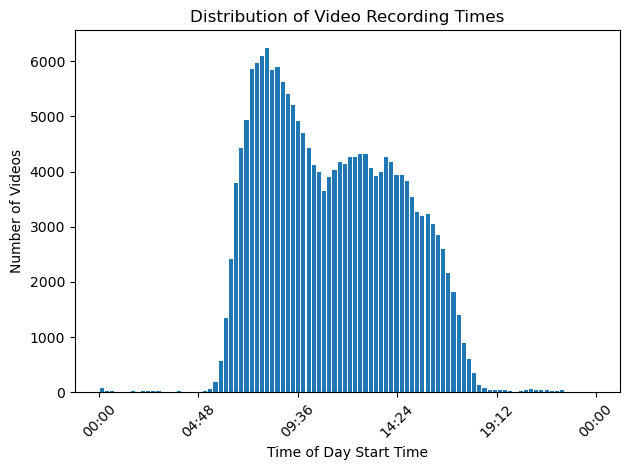

In [18]:
from datetime import datetime

stmt = (
    select(Video.start_time)
)

with session_cls() as session:
    result = session.execute(stmt)
    all = result.fetchall()
    all_times = [mdates.date2num(datetime.combine(datetime.today(), t[0].time())) for t in all if t[0] is not None]
    
fig, ax = plt.subplots()
ax.hist(all_times, bins=24 * 4, rwidth=0.8)
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
plt.xlabel("Time of Day Start Time")
plt.ylabel("Number of Videos")
plt.title("Distribution of Video Recording Times")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()